# Ensemble models

gwlearn currently implements geographically weighted versions of ensemble models for the classification tasks. However, there's a caveat. Given it is unlikely that all categories are present in all local models, fitting a non-binary would lead to inconsistent local models. Hence gwlearn currently supports only binary classification.

In [1]:
import geopandas as gpd
from geodatasets import get_path
from sklearn import metrics

from gwlearn.ensemble import GWGradientBoostingClassifier, GWRandomForestClassifier

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr")).to_crs(5070)

gdf['point'] = gdf.representative_point()
gdf = gdf.set_geometry('point')

y = gdf["FH90"] > gdf["FH90"].median()
X = gdf.iloc[:, 9:15]

## Random Forest

The implementation of geographically-weighted random forest classifier follows the logic of linear models, where each local neighborhood defiend by a set bandwidth is used to fit a single local model. 

In [3]:
gwrf = GWRandomForestClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
)
gwrf.fit(
    X,
    y,
)

GWRandomForestClassifier(bandwidth=250,
                         geometry=0          POINT (82374.171 2869835.025)
1       POINT (-1666267.814 3025996.603)
2        POINT (-1618645.796 3012447.96)
3       POINT (-1751938.544 3053013.371)
4       POINT (-1576454.985 3002625.267)
                      ...               
3080    POINT (-1658725.535 1280845.161)
3081        POINT (-1089589 1376092.326)
3082     POINT (1700687.417 1750877.094)
3083     POINT (1588266.678 1896903.045)
3084    POINT (-1153940.634 2574551.428)
Name: point, Length: 3085, dtype: geometry)

### Focal score

The performance of these models can be measured in three ways. The first one is using the focal prediction. Unlike in linear models, where the focal observation is part of the local model training, in this case it is excluded to ensure it can be used to evaluate the model. Otherwise, it would be a part of the data the local model has seen and would report unrealistically high performance. If you want to include the focal observation in the training nevertheless, just set `include_focal=True`.

Focal accuracy can be measured as follows. Note that some local models are not fitted due to [imbalance rules](imbalance.ipynb), and report NA that needs to be filtered out.

In [4]:
na_mask = gwrf.pred_.notna()

metrics.accuracy_score(y[na_mask], gwrf.pred_[na_mask])

0.7635574837310195

### Pooled out-of-bag score

Another option is to pull the out-of-bag predictions from individual local models and pool them together. This uses more data to evaluate the model but given the local models are tuned for their focal location, some predictions on locations far from the focal point may be artifically worse than the actual model prediction would be.

In [5]:
metrics.accuracy_score(gwrf.oob_y_pooled_, gwrf.oob_pred_pooled_)

0.7639566160520608

### Local score

The final option is to take the local out-of-bag predicitons and measure performance per each local model. To do that, you can use a method `local_metric()`.

In [6]:
local_accuracy = gwrf.local_metric(metrics.accuracy_score)
local_accuracy

array([  nan, 0.812, 0.824, ..., 0.732, 0.704, 0.848], shape=(3085,))

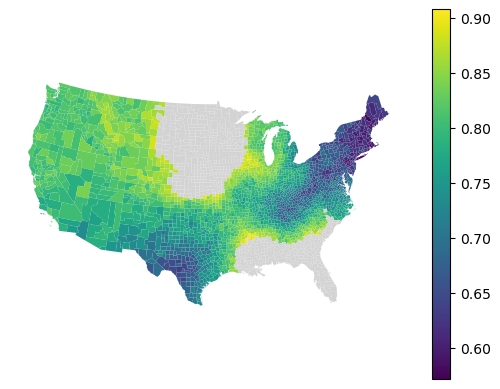

In [17]:
gdf.set_geometry('geometry').plot(local_accuracy, legend=True, missing_kwds=dict(color='lightgray')).set_axis_off()

### Feature importance

Feature importances are reported for each local model.

In [8]:
gwrf.feature_importances_

HR60      HR70      HR80      HR90      HC60      HC70
0          NaN       NaN       NaN       NaN       NaN       NaN
1     0.179267  0.139123  0.124227  0.160139  0.197307  0.199936
2     0.178505  0.136469  0.130985  0.170816  0.168485  0.214740
3     0.144078  0.133436  0.129812  0.165222  0.165138  0.262315
4     0.149554  0.142001  0.118353  0.160402  0.182540  0.247150
...        ...       ...       ...       ...       ...       ...
3080  0.145577  0.092096  0.202522  0.097916  0.290165  0.171724
3081  0.145981  0.096929  0.158639  0.198414  0.234700  0.165337
3082  0.143242  0.215822  0.186652  0.222352  0.094151  0.137781
3083  0.161037  0.167594  0.188477  0.266096  0.092027  0.124768
3084  0.096781  0.129547  0.160739  0.189850  0.213452  0.209630

[3085 rows x 6 columns]

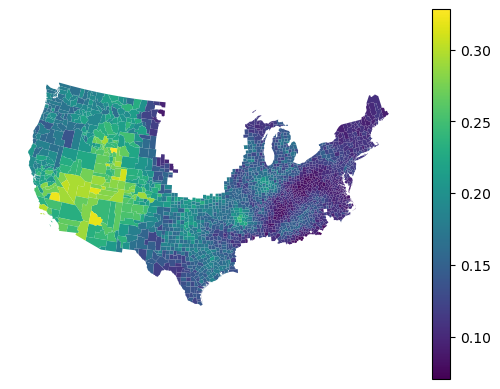

In [18]:
gdf.set_geometry('geometry').plot(gwrf.feature_importances_["HC60"], legend=True).set_axis_off()

You can compare all of this to values extracted from a global model, fitted alongside.

In [10]:
gwrf.global_model.feature_importances_

array([0.13568658, 0.14795968, 0.18836118, 0.20578669, 0.14827197,
       0.17393389])

In [11]:
gwrf.feature_importances_.mean()

HR60    0.142798
HR70    0.156280
HR80    0.189687
HR90    0.191350
HC60    0.146587
HC70    0.173299
dtype: float64

## Gradient boosting

If you prefer to use gradient boosting, there is a minimal implementation of geographically weighted gradient boosting classifier, following the same model described for the random forest above.

In [12]:
gwgb = GWGradientBoostingClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
)
gwgb.fit(
    X,
    y,
)

GWGradientBoostingClassifier(bandwidth=250,
                             geometry=0          POINT (82374.171 2869835.025)
1       POINT (-1666267.814 3025996.603)
2        POINT (-1618645.796 3012447.96)
3       POINT (-1751938.544 3053013.371)
4       POINT (-1576454.985 3002625.267)
                      ...               
3080    POINT (-1658725.535 1280845.161)
3081        POINT (-1089589 1376092.326)
3082     POINT (1700687.417 1750877.094)
3083     POINT (1588266.678 1896903.045)
3084    POINT (-1153940.634 2574551.428)
Name: point, Length: 3085, dtype: geometry)

Given the nature of the model, the outputs are a bit more limited. You can still extract focal predictions.

In [13]:
nan_mask = gwgb.pred_.notna()

metrics.accuracy_score(y[nan_mask], gwgb.pred_[nan_mask])

0.7483731019522777

And local feature importances.

In [14]:
gwgb.feature_importances_

HR60      HR70      HR80      HR90      HC60      HC70
0          NaN       NaN       NaN       NaN       NaN       NaN
1     0.173350  0.122193  0.066879  0.161867  0.134879  0.340832
2     0.189628  0.122011  0.063924  0.163806  0.118613  0.342017
3     0.146307  0.139012  0.077630  0.170284  0.071027  0.395741
4     0.166607  0.133140  0.072732  0.159727  0.111422  0.356372
...        ...       ...       ...       ...       ...       ...
3080  0.099314  0.056185  0.143100  0.045828  0.592708  0.062865
3081  0.088293  0.067453  0.139627  0.227565  0.442186  0.034876
3082  0.101723  0.190659  0.173942  0.335706  0.063783  0.134187
3083  0.136217  0.164555  0.158056  0.363580  0.047310  0.130281
3084  0.028864  0.100108  0.098761  0.224582  0.430143  0.117543

[3085 rows x 6 columns]

### Leave out samples

However, the pooled data are not available. In this case, you can use the `leave_out` keyword to leave out a fraction (when float) or a set number (when int) of random observations from each local model. For these, the local model does prediction and returns as `left_out_proba_` and `left_out_y_` arrays.

In [15]:
gwgb_leave = GWGradientBoostingClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
    leave_out=.2
)
gwgb_leave.fit(
    X,
    y,
)

GWGradientBoostingClassifier(bandwidth=250,
                             geometry=0          POINT (82374.171 2869835.025)
1       POINT (-1666267.814 3025996.603)
2        POINT (-1618645.796 3012447.96)
3       POINT (-1751938.544 3053013.371)
4       POINT (-1576454.985 3002625.267)
                      ...               
3080    POINT (-1658725.535 1280845.161)
3081        POINT (-1089589 1376092.326)
3082     POINT (1700687.417 1750877.094)
3083     POINT (1588266.678 1896903.045)
3084    POINT (-1153940.634 2574551.428)
Name: point, Length: 3085, dtype: geometry)

In [16]:
metrics.accuracy_score(gwgb_leave.left_out_y_, gwgb_leave.left_out_proba_.argmax(axis=1))

0.7502559652928417